# INFS5705 AI for Business Analytics in Practice
## Week 3 Workshop Hands-On Activity 2 – Logistic Regression and Decision Tree in Python
### Let’s predict product returns using logistic regression, and decision tree in Python

GlobalStore Inc., a leading international online retailer, faces a significant challenge with returned merchandise. The company experienced a substantial volume of their sales returned by unhappy customers, resulting in financial losses and a decline in customer satisfaction. Furthermore, many returned items were damaged and often went to waste, raising environmental concerns, particularly regarding e-waste. Manual handling of e-waste is labour-intensive and prone to errors, leading to increased costs.

To mitigate these issues, GlobalStore plans to harness the power of AI-driven business analytics to accurately predict return likelihood. By identifying potential returns before they happen, the company can take preventive measures to reduce the number of returned products, thereby increasing revenues.

In this workshop hands-on activity, we would like to predict product returns. To do that, we will train AI models using a large dataset of orders available on Moodle as a CSV file called global_store.csv under the Week 3 section.

First, upload the dataset csv file into this notebook on Google Colab.

Once the dataset is uploaded, you can conduct the following steps.

### Importing Libraries

The following libraries cover the required libraries for logistic regression and decision tree. These libraries will help manipulate data, split it into training and testing sets, build our model, and evaluate its performance.

- pandas: Load and manipulate data in DataFrame format for analysis.
- numpy: Perform numerical operations and array manipulations.
- train_test_split: Split data into training and testing sets.
- LogisticRegression: Build and train logistic regression models.
- DecisionTreeClassifier: Build and train decision tree models.
- export_text: Export decision tree structure as text.
- plot_tree: Visualize decision tree structure.
- accuracy_score: Calculate model accuracy.
- mean_absolute_error: Compute mean absolute error for regression evaluation.
- mean_squared_error: Compute mean squared error for regression evaluation.
- confusion_matrix: Generate confusion matrix to evaluate classification performance.
- classification_report: Provide detailed classification metrics (precision, recall, F1-score).
- class_weight: Compute class weights for handling imbalanced datasets.
- preprocessing: Preprocess data (e.g., scaling, encoding) for model input.
- sns: Create enhanced visualizations for data analysis.
- pyplot: Plot graphs and visualizations.
- pandas.api.types: Check data types, useful for data transformation.

In [12]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from sklearn import preprocessing
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.api.types import is_numeric_dtype, is_categorical_dtype, is_bool_dtype

### Loading the Data

Next, we need to load our dataset. To do so, you can download the dataset from Moodle as a CSV file called ‘global_store.csv’ and upload it to your Colab notebook.

Let's load the dataset from the csv file provided as follows:


In [17]:
# Load the data
data = pd.read_csv('global_store.csv')

> **Explanation of the code:** The code data = pd.read_csv('/content/global_store.csv') reads the data from CSV file 'global_store.csv' and l stores it in a variable called data using the read_csv function from the pandas library (aliased as pd).

### Data Cleaning

In this step we need to check if there are missing values.

In [18]:
# Check for missing values
missing_values = data.isna()
print(missing_values.any().any())

True


This dataset does not include any missing values. This is demonstrated by False in the result of the code.

In case the above code produces True, this means that the dataset includes missing values and you need address that using the following code.

In [19]:
# Remove rows with missing values, if any
data = data.dropna()

### Data Transformation

Next, we need to convert data into numeric or categorical data. You can check the data type of all variables using the following code.

In [20]:
# Check the data type of all variables
print(data.dtypes)

asin                          object
color                         object
ratings                      float64
number_of_ratings            float64
price                          int64
discount                      object
brand                         object
os                            object
cpu_model                     object
resolution                    object
name                          object
wireless_carrier              object
cellular_technology           object
model                         object
amazon_renewed                  bool
battery_capacity              object
battery_power                 object
charging_time                 object
ram                           object
storage                       object
screen_size                   object
connectivity_technologies     object
wireless_network              object
cpu_speed                     object
best_seller_last_month          bool
dtype: object


In [21]:
# Convert categorical/object-type columns to 'category' type
categorical_cols = [
    'brand', 'os', 'color', 'wireless_carrier', 'cellular_technology',
    'cpu_model', 'resolution', 'model', 'connectivity_technologies',
    'wireless_network'
]

for col in categorical_cols:
    if col in data.columns and data[col].dtype == 'object':
        data[col] = data[col].astype('category')

# Convert the target variable to boolean
data['best_seller_last_month'] = data['best_seller_last_month'] == 'Yes'



You can have a look at the data type of all variables in the dataset to check that the transformation has been applied.

In [22]:
# Check the data type of all variables
print(data.dtypes)

asin                           object
color                        category
ratings                       float64
number_of_ratings             float64
price                           int64
discount                       object
brand                        category
os                           category
cpu_model                    category
resolution                   category
name                           object
wireless_carrier             category
cellular_technology          category
model                        category
amazon_renewed                   bool
battery_capacity               object
battery_power                  object
charging_time                  object
ram                            object
storage                        object
screen_size                    object
connectivity_technologies    category
wireless_network             category
cpu_speed                      object
best_seller_last_month           bool
dtype: object


One important preprocessing step is scaling the data.

What is Scaling Data?

Scaling data means adjusting the range of features so that they have a standard scale. This is particularly important for ML algorithms that rely on the distances between data points, such as logistic regression and linear regression.

Why is Scaling Important?

It ensures that all features contribute equally to the model's predictions. Without scaling, features with larger ranges might dominate the learning process. It helps gradient-based optimisation algorithms converge faster. Models often perform better when the data is scaled. Some algorithms can be sensitive to large differences in the scale of data, leading to numerical stability issues.

In [23]:

data = pd.read_csv('global_store.csv') 

# Fill missing values for numeric columns using the median
for col in data.select_dtypes(include=['float64', 'int64']).columns:
    data[col] = data[col].fillna(data[col].median())

# Fill missing values for object/categorical columns using a placeholder
for col in data.select_dtypes(include='object').columns:
    data[col] = data[col].fillna('Unknown')


### Feature Selection

In this step, we will perform feature selection. Feature selection is crucial because it involves choosing the right variables (features) that will help us make accurate predictions.

As we discussed in Week 2 seminar, feature selection allows to select relevant features (variables) to build the model. Feature selection improves the model's performance by removing irrelevant or less important features, reduce the complexity of the model, which can make it faster to train and easier to interpret, and preventing overfitting.

We need to select the key variables that might affect the target variable ‘returned’.

Initial feature selection (i.e. selecting which variables should be included in X) as follows:

* You can exclude variables that represent unique identifiers because they don't have any impact on the target variable.

* You can exclude variables that are text descriptions and not useful as categories.

* You can exclude categorical variables that have too many possible values, as these would generate too many dummy variables. A model with too many variables cannot perform well and sometimes cause the machine to run out of memory. This would also help you focus on the most important variables.


In [24]:
drop_cols = [
    "returned", "order_id", "customer_id", "product_id", "product_name", 
    "order_date", "shipping_date", "market", "region", "country", "state", 
    "city", "sub_category", "order_priority"
]

# Filter only the columns that are present in the DataFrame
drop_existing = [col for col in drop_cols if col in data.columns]

# Split data into features (X) and target (y)
X = data.drop(columns=drop_existing)
y = data["best_seller_last_month"]

Why did we exclude "returned", "order_id", "customer_id", "product_id", "product_name", "order_date", "shipping_date", "market", "region", "country", "state", "city", "sub_category", and "order_priority"?

For example, in our dataset, we have a column called customer_id. This column is simply an identifier for each customer and does not provide any relevant information for predicting whether a product will be returned or not. Including customer_id in our model would not make sense because it does not influence customer behaviour to return the product or not. customer_id is just a unique identifier assigned to each customer. It doesn't contain any information about the customer's behaviour or characteristics that could influence whether the product is returned or not. Therefore, we exclude it from our input features.

Likewise, the column returned is our target variable, which indicates whether a product is returned or not. This column should not be included in the input features because it is what we are trying to predict.


Further feature selection using 2 different methods

- Pair Plot: Shows scatter plots or box plots for pairs of features to visualise the relationships between features.

- Correlation Matrix Heatmap: Visualises the correlation coefficients between features and the target variable.

**Pair Plots**

This code plots each feature against the target variable using appropriate plots in a grid depending on whether the feature and target variables are numeric, boolean or categorical. It plots either a Box Plot, a Scatter Plot, or Count Plot.

C:\Users\MSI APACHE PRO\AppData\Local\Temp\ipykernel_9868\946718977.py:3: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  target_is_categorical = is_categorical_dtype(y)
C:\Users\MSI APACHE PRO\AppData\Local\Temp\ipykernel_9868\946718977.py:23: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  feature_is_categorical = is_categorical_dtype(X[feature])
C:\Users\MSI APACHE PRO\AppData\Local\Temp\ipykernel_9868\946718977.py:23: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  feature_is_categorical = is_categorical_dtype(X[feature])
C:\Users\MSI APACHE PRO\AppData\Local\Temp\ipykernel_9868\946718977.py:23: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future ver

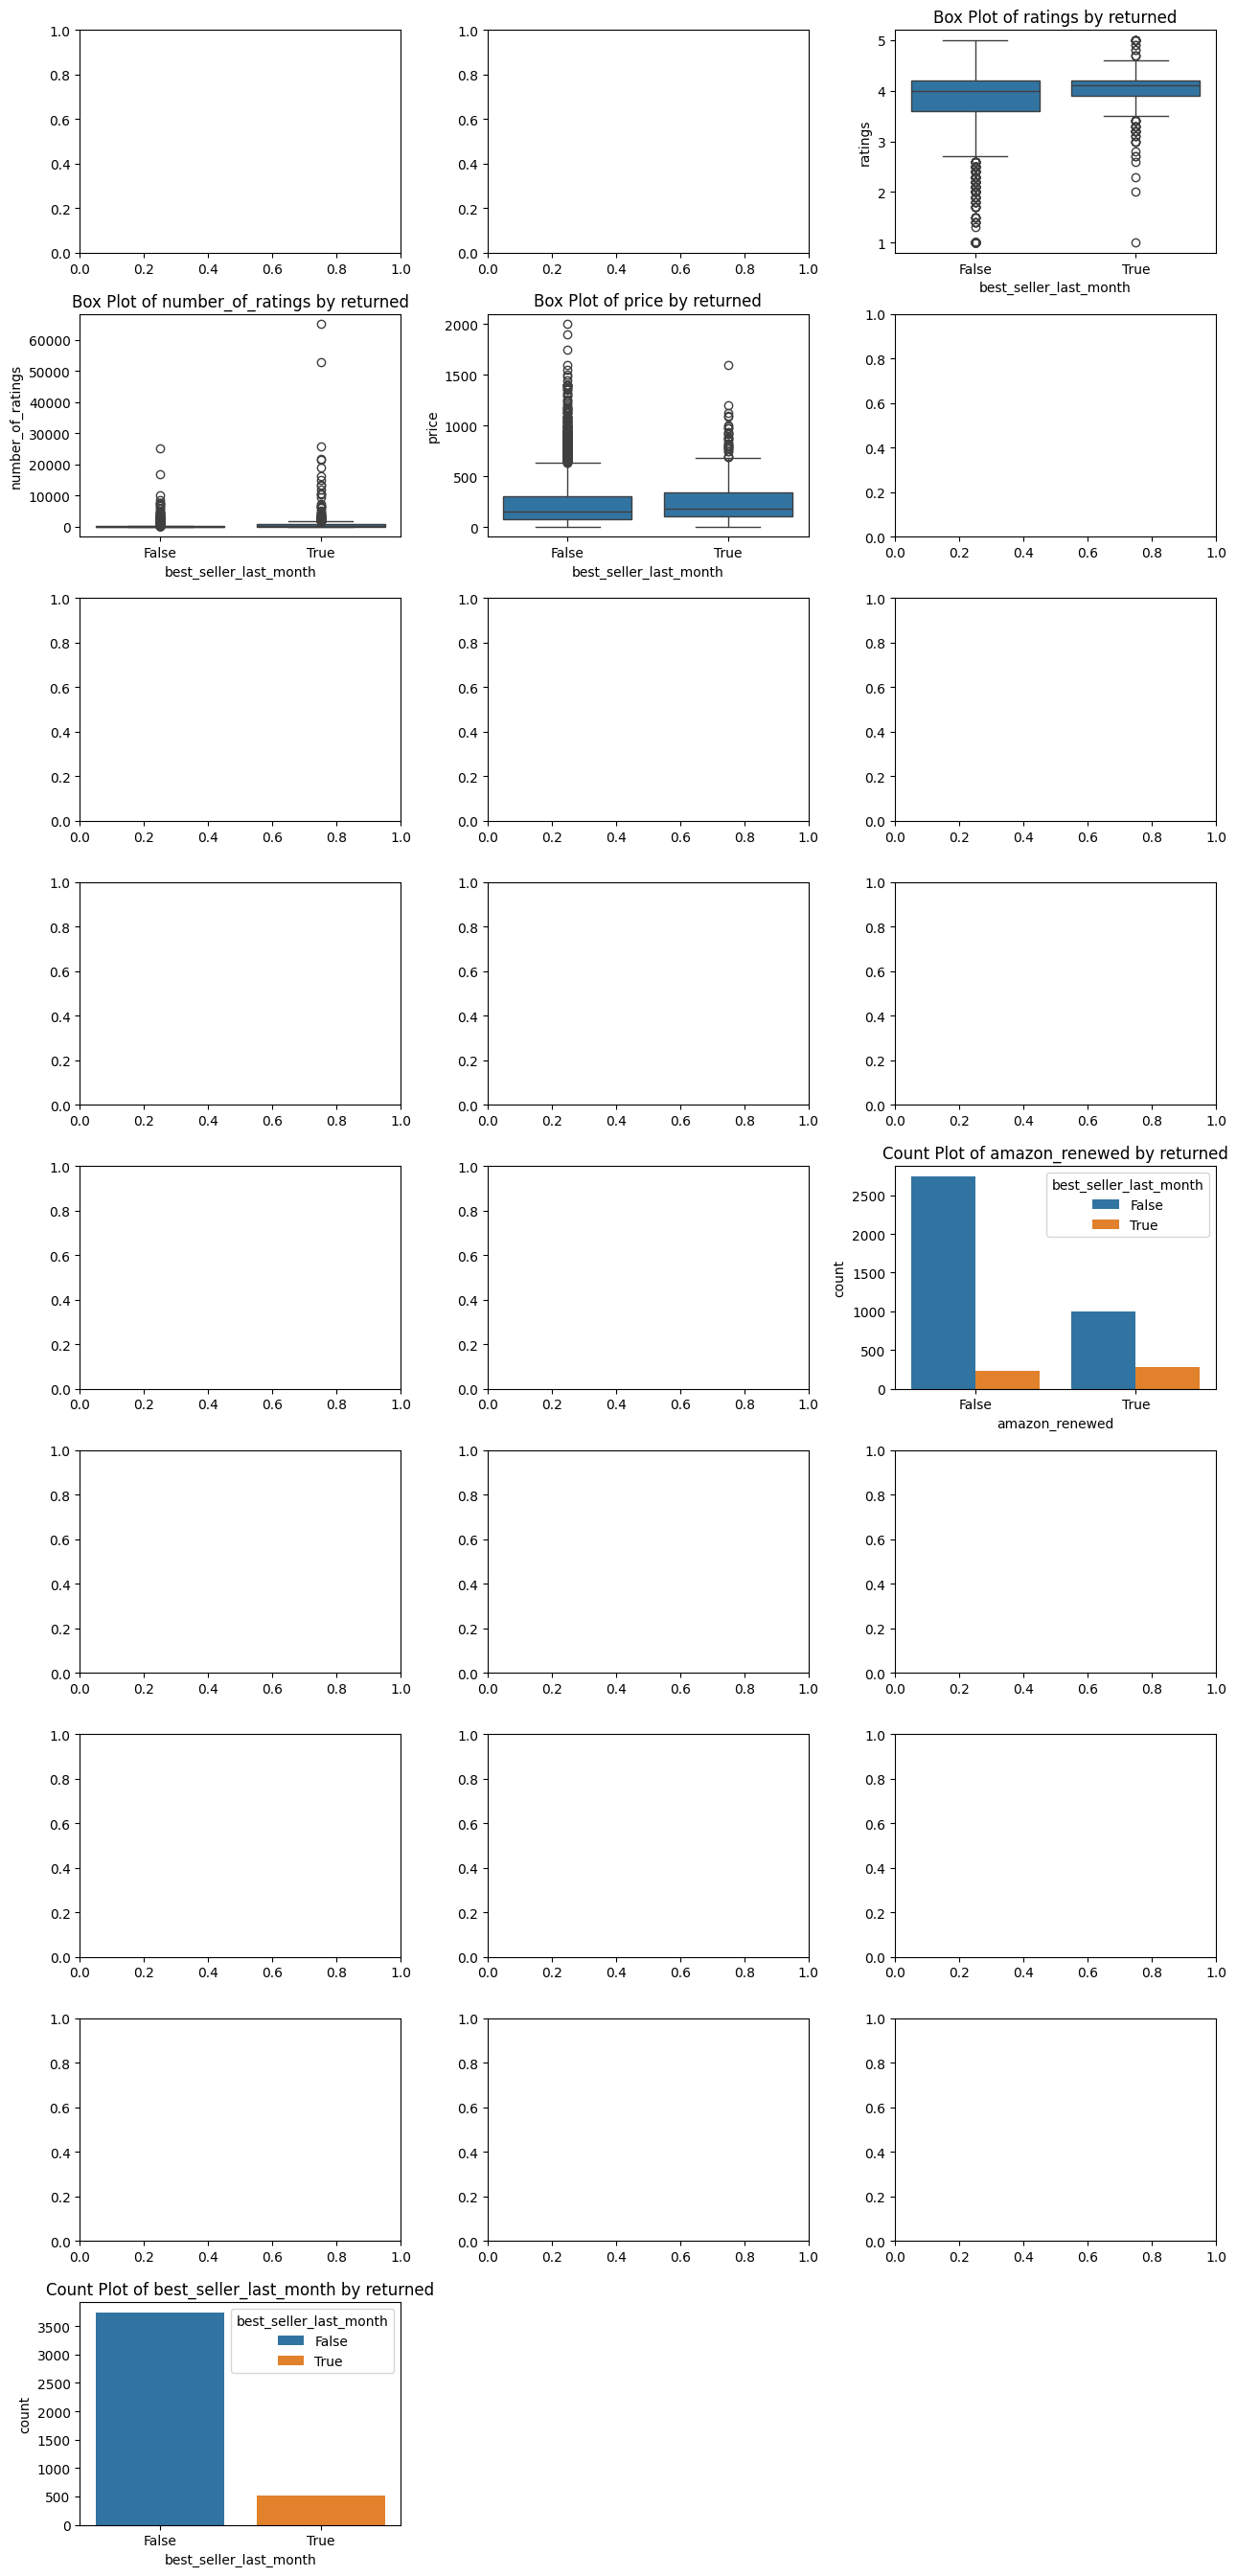

In [25]:
# Determine the type of the target variable
target_is_numeric = is_numeric_dtype(y) and not is_bool_dtype(y)
target_is_categorical = is_categorical_dtype(y)
target_is_boolean = is_bool_dtype(y)

target = "returned"

# Plot each feature against the target variable using appropriate plots in a grid
num_features = len(X.columns)
num_cols = 3
num_rows = (num_features + num_cols - 1) // num_cols  # Ceiling division

fig, axes = plt.subplots(num_rows, num_cols, figsize=(13, num_rows * 3))

# Plot each feature against the target variable
for i, feature in enumerate(X.columns):
    row = i // num_cols
    col = i % num_cols
    ax = axes[row, col]
    # Determine the type of the feature
    feature_is_numeric = is_numeric_dtype(X[feature]) and not is_bool_dtype(X[feature])
    feature_is_boolean = is_bool_dtype(X[feature])
    feature_is_categorical = is_categorical_dtype(X[feature])

    # Select appropriate plot
    if (target_is_categorical or target_is_boolean) and feature_is_numeric:
        sns.boxplot(x=y, y=X[feature], ax=ax)
        ax.set_title(f'Box Plot of {feature} by {target}')
    elif target_is_numeric and feature_is_numeric:
        sns.scatterplot(x=X[feature], y=y, ax=ax)
        ax.set_title(f'Scatter Plot of {feature} vs {target}')
    elif (target_is_categorical or target_is_boolean) and (feature_is_boolean or feature_is_categorical):
        sns.countplot(x=X[feature], hue=y, ax=ax)
        ax.set_title(f'Count Plot of {feature} by {target}')
    elif target_is_numeric and (feature_is_boolean or feature_is_categorical):
        sns.boxplot(x=X[feature], y=y, ax=ax)
        ax.set_title(f'Box Plot of {target} by {feature}')

# Remove any empty subplots
for i in range(num_features, num_rows * num_cols):
    fig.delaxes(axes.flatten()[i])

# Adjust layout
plt.tight_layout()
plt.show()

> **Explanation of the results and feature selection:** You need to inspect each plot and decide whether it indicates a possible effect. If the plot shows similar data for returned = True vs returned = False, then it is unlikely that the corresponding feature has an effect. For example, the various shipping modes seems to have similar ratios of returned = True vs False, potentially indicating that shipping modes have low effect on product returns. In this case, we may chose to exclude them from the predictors to train the model. Further results from the correlation matrix can help provide better evaluation of the effect of each variable as follows.

**Correlation Matrix Heatmap**

A Correlation Matrix Heatmap shows the correlation coefficients between all features and the target variable. High absolute correlation with the target may indicate important features.

First, we need to convert categorical variables into dummy variables to include individual categories as variables. Please make sure that you do this before constructing the correlation heatmap. This would help you identify the most important features to be included in your models. It is also important to do this before training the models.

In [26]:
# Convert categorical variables into dummy variables to include individual categories as variables.
X = pd.get_dummies(X, drop_first=True)

Let's plot the correlation matrix heatmap to check which variables are important (i.e. correlated with the target variable).

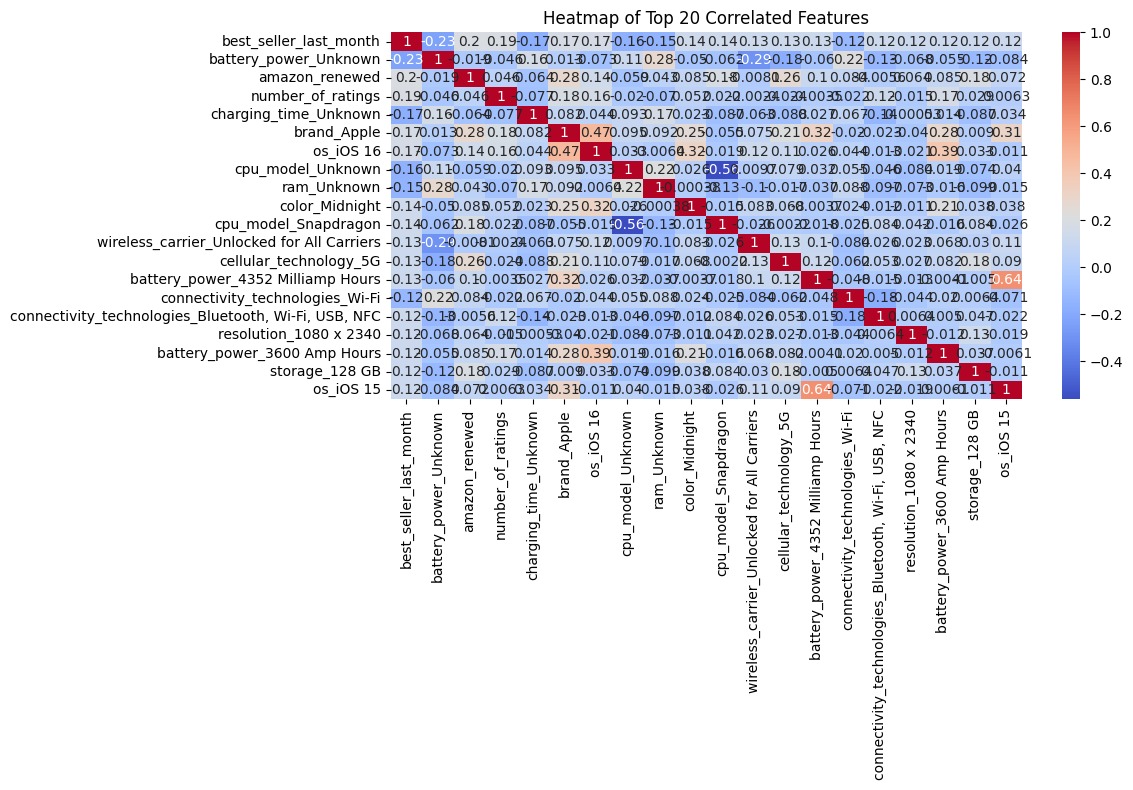

In [ ]:
# Step 1: Merge X and y for correlation
target_corr = X.apply(lambda col: col.corr(y)).abs().nlargest(20)

top_features = target_corr.index
corr_matrix_top = X[top_features].corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix_top, cmap="coolwarm", annot=True)
plt.title("Heatmap of Top 20 Correlated Features")
plt.tight_layout()
plt.show()


Further feature selection based on the results of pair plots and/or correlation matrix heatmap.

You can exclude variables that are not correlated with the target variable.

When 2 variables (other than the target variable) are highly correlated to each other, you can remove one of them to address multi-colinearity problem (keep the one that is highly correlated with the target variable).

In [27]:
# Further feature selection based on the results of pair plots and/or correlation matrix heatmap.
# X = X.drop(columns=['shipping_mode_Same Day', 'shipping_mode_Second Class', 'category_Technology', 'season_Christmas', 'season_MothersDay',
#        'season_NewYear', 'season_Valentine', 'shipping_cost', 'profit'])


to_drop = ['shipping_mode_Same Day', 'shipping_mode_Second Class', 'category_Technology', 
           'season_Christmas', 'season_MothersDay', 'season_NewYear', 'season_Valentine', 
           'shipping_cost', 'profit']

existing_drop = [col for col in to_drop if col in X.columns]

X = X.drop(columns=existing_drop)

### Split the data into training and testing sets

Before we train our model, we need to split our data into two parts: training and testing sets. The training set will be used to train the model, while the testing set will be used to test the accuracy of the model; how well our model performs to make predictions.

To split our data into training and testing sets, we use the function ‘train_test_split(X, y, test_size=0.2)’

The ‘test_size=0.2’ parameter means that 20% of the data will be used for testing, and the remaining 80% will be used for training.

In [28]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Train and test a Logistic Regression Model

In [29]:
# Train a logistic regression model on the training data.
# If your dataset is highly imbalanced, the model might predict the majority class for all instances.
# An imbalanced dataset for a binary target variable like "returned" means that the number of cases of one class is much smaller or much larger than the number of cases of the other class.
# You can enable Class Weight Adjustment (class_weight='balanced') to adjust the class weights in the logistic regression model to give more importance to the minority class.

model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='macro')  # or 'micro', 'weighted' depending on your need
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

#Display feature coefficients
coefficients = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': model.coef_[0]
})
print(coefficients)

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
                      Feature  Coefficient
0                     ratings     0.059446
1           number_of_ratings     0.000134
2                       price    -0.000204
3              amazon_renewed     0.559993
4      best_seller_last_month     9.405979
...                       ...          ...
11885       cpu_speed_765 GHz    -0.004863
11886       cpu_speed_800 MHz    -0.003061
11887      cpu_speed_9.04 GHz     0.015388
11888       cpu_speed_9.6 GHz    -0.004326
11889       cpu_speed_Unknown    -0.079278

[11890 rows x 2 columns]


**Interpretation of the results**

- Accuracy of a Logistic Regression Model

Accuracy measures how often the model correctly predicts the outcome. It is calculated as the ratio of correct predictions to the total number of predictions made. A high accuracy score (close to 1 or 100%) indicates that the model is performing well, correctly predicting most of the outcomes. A low accuracy score (close to 0) suggests that the model is not performing well and is making incorrect predictions more often.

The accuracy score of 0.5387 (approximately 53.87%) means that the model correctly predicted the outcome (Target Variable - Whether a product is returned or not) around 53.87% of the time. In other words, out of 100 predictions, the model is expected to correctly predict about 53 times. Whether an accuracy of 53.87% is considered good depends on the context of the problem and the baseline performance (e.g., random guessing or the accuracy of simpler models). For some problems, this might be a satisfactory score, while for others, it may require further improvement. The improvement could be better feature selection, more data transformation, etc.

In this case, an accuracy of 53.87% suggests that the Logistic Regression model is moderately good at predicting the outcomes, but there might be potential for improvement. Analysing and tweaking various aspects of the data and the model can help enhance its performance.

- Precision, Recall, and F1 metrics

Precision measures how many of the predicted positive outcomes were actually positive. High precision indicates that there are fewer false positives.

The results show that Precision equals 0.5082 (or approximately 50.82%). This means that out of all the products (order) the model predicted would be returned, approximately 50.82% of them actually were returned. This indicates that the model's positive predictions (product returned) are correct 50.82% of the time.

In terms of insights, we could say that this finding shows that while the model is fairly good at identifying true product returns, there is still a significant proportion of false positives (products predicted to be returned but were not actually returned). High precision is crucial when the cost of false positives is high. In product returns, false positives could lead to unnecessary focus on products that do not actually generate a lot of return. By ensuring that the model’s predictions are accurate, you avoid wasting resources and efforts on improvements to products that are not actually at risk of return.

Recall measures how many of the actual positive outcomes were correctly predicted by the model. High recall indicates that there are fewer false negatives.

The results show that Recall equals 0.5354 (or approximately 53.54%). The model correctly identified 53.54% of the actual returned products. This means that out of all products that were actually returned, the model was able to identify nearly 53.54%. However, this means that 44.84% of products returned are not being captured by the model.

High recall is important when the cost of false negatives is high. In the context of product returns, false negatives are products that are returned but are not identified by the model. Not being able to identify these products means missing on the opportunity to solve the problem, as no improvement efforts will be made to reduce the risk of return.

The F1 Score is the harmonic mean of precision and recall. It provides a balance between precision and recall, especially useful when you need to find a balance between the two. It is especially useful when you need to balance the trade-off between Precision and Recall, and when you have an imbalanced dataset.

The results show that F1 Score equals 0.4056 (or approximately 40.56%). This score indicates that the model has a moderate performance, with both precision and recall being considered. This means that the model is moderately good at both identifying actual returns and ensuring that its positive predictions are accurate.

- Feature Coefficients

The coefficients in the table indicate how each feature impacts the likelihood of a product return. By understanding these coefficients, we can identify which factors are most important in predicting product return and take appropriate actions to address them. To determine if the variables are strong predictors of product return, we need to consider the context of the coefficient value relative to other features and the overall model.

For example, let's determine if 'discount' (-0.199539) is a strong predictor of product return by comparing it to the other features.

Coefficient Value: The coefficient for 'discount' is -0.199539. This means that an increase in discount is associated with an decrease in the likelihood of product return. In other words, customers who purchase a discounted product are less likely to return it.

Magnitude: The absolute value 0.199539 indicates the strength of the relationship between 'discount' and product return. To understand if this is a strong predictor, we need to compare it with the magnitudes of other coefficients.

Relative Strength: Compared to other features, 'discount' has a higher absolute value than all other features like 'quantity' (0.194222), 'season_Halloween' (0.15), etc.

Therefore, based on the coefficient value of -0.199539, 'discount' is a significant predictor / strong indicator of product return. A negative coefficient means that higher discount is associated with a lower likelihood of product return. A plausible explanation for this finding could be that customers who purchase discounted products have lower expectations or might feel like they made a good deal, which could lead to more satisfaction.

Actionable insights and recommendations: Since 'discount' is a strong predictor, we can recommend the business to focus its discounts on products that have high returns to reduce their likelihood to be returned.

Think of other features that might have a strong effect on product returns. What about season_Halloween?

## Train a Decision Tree Model

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


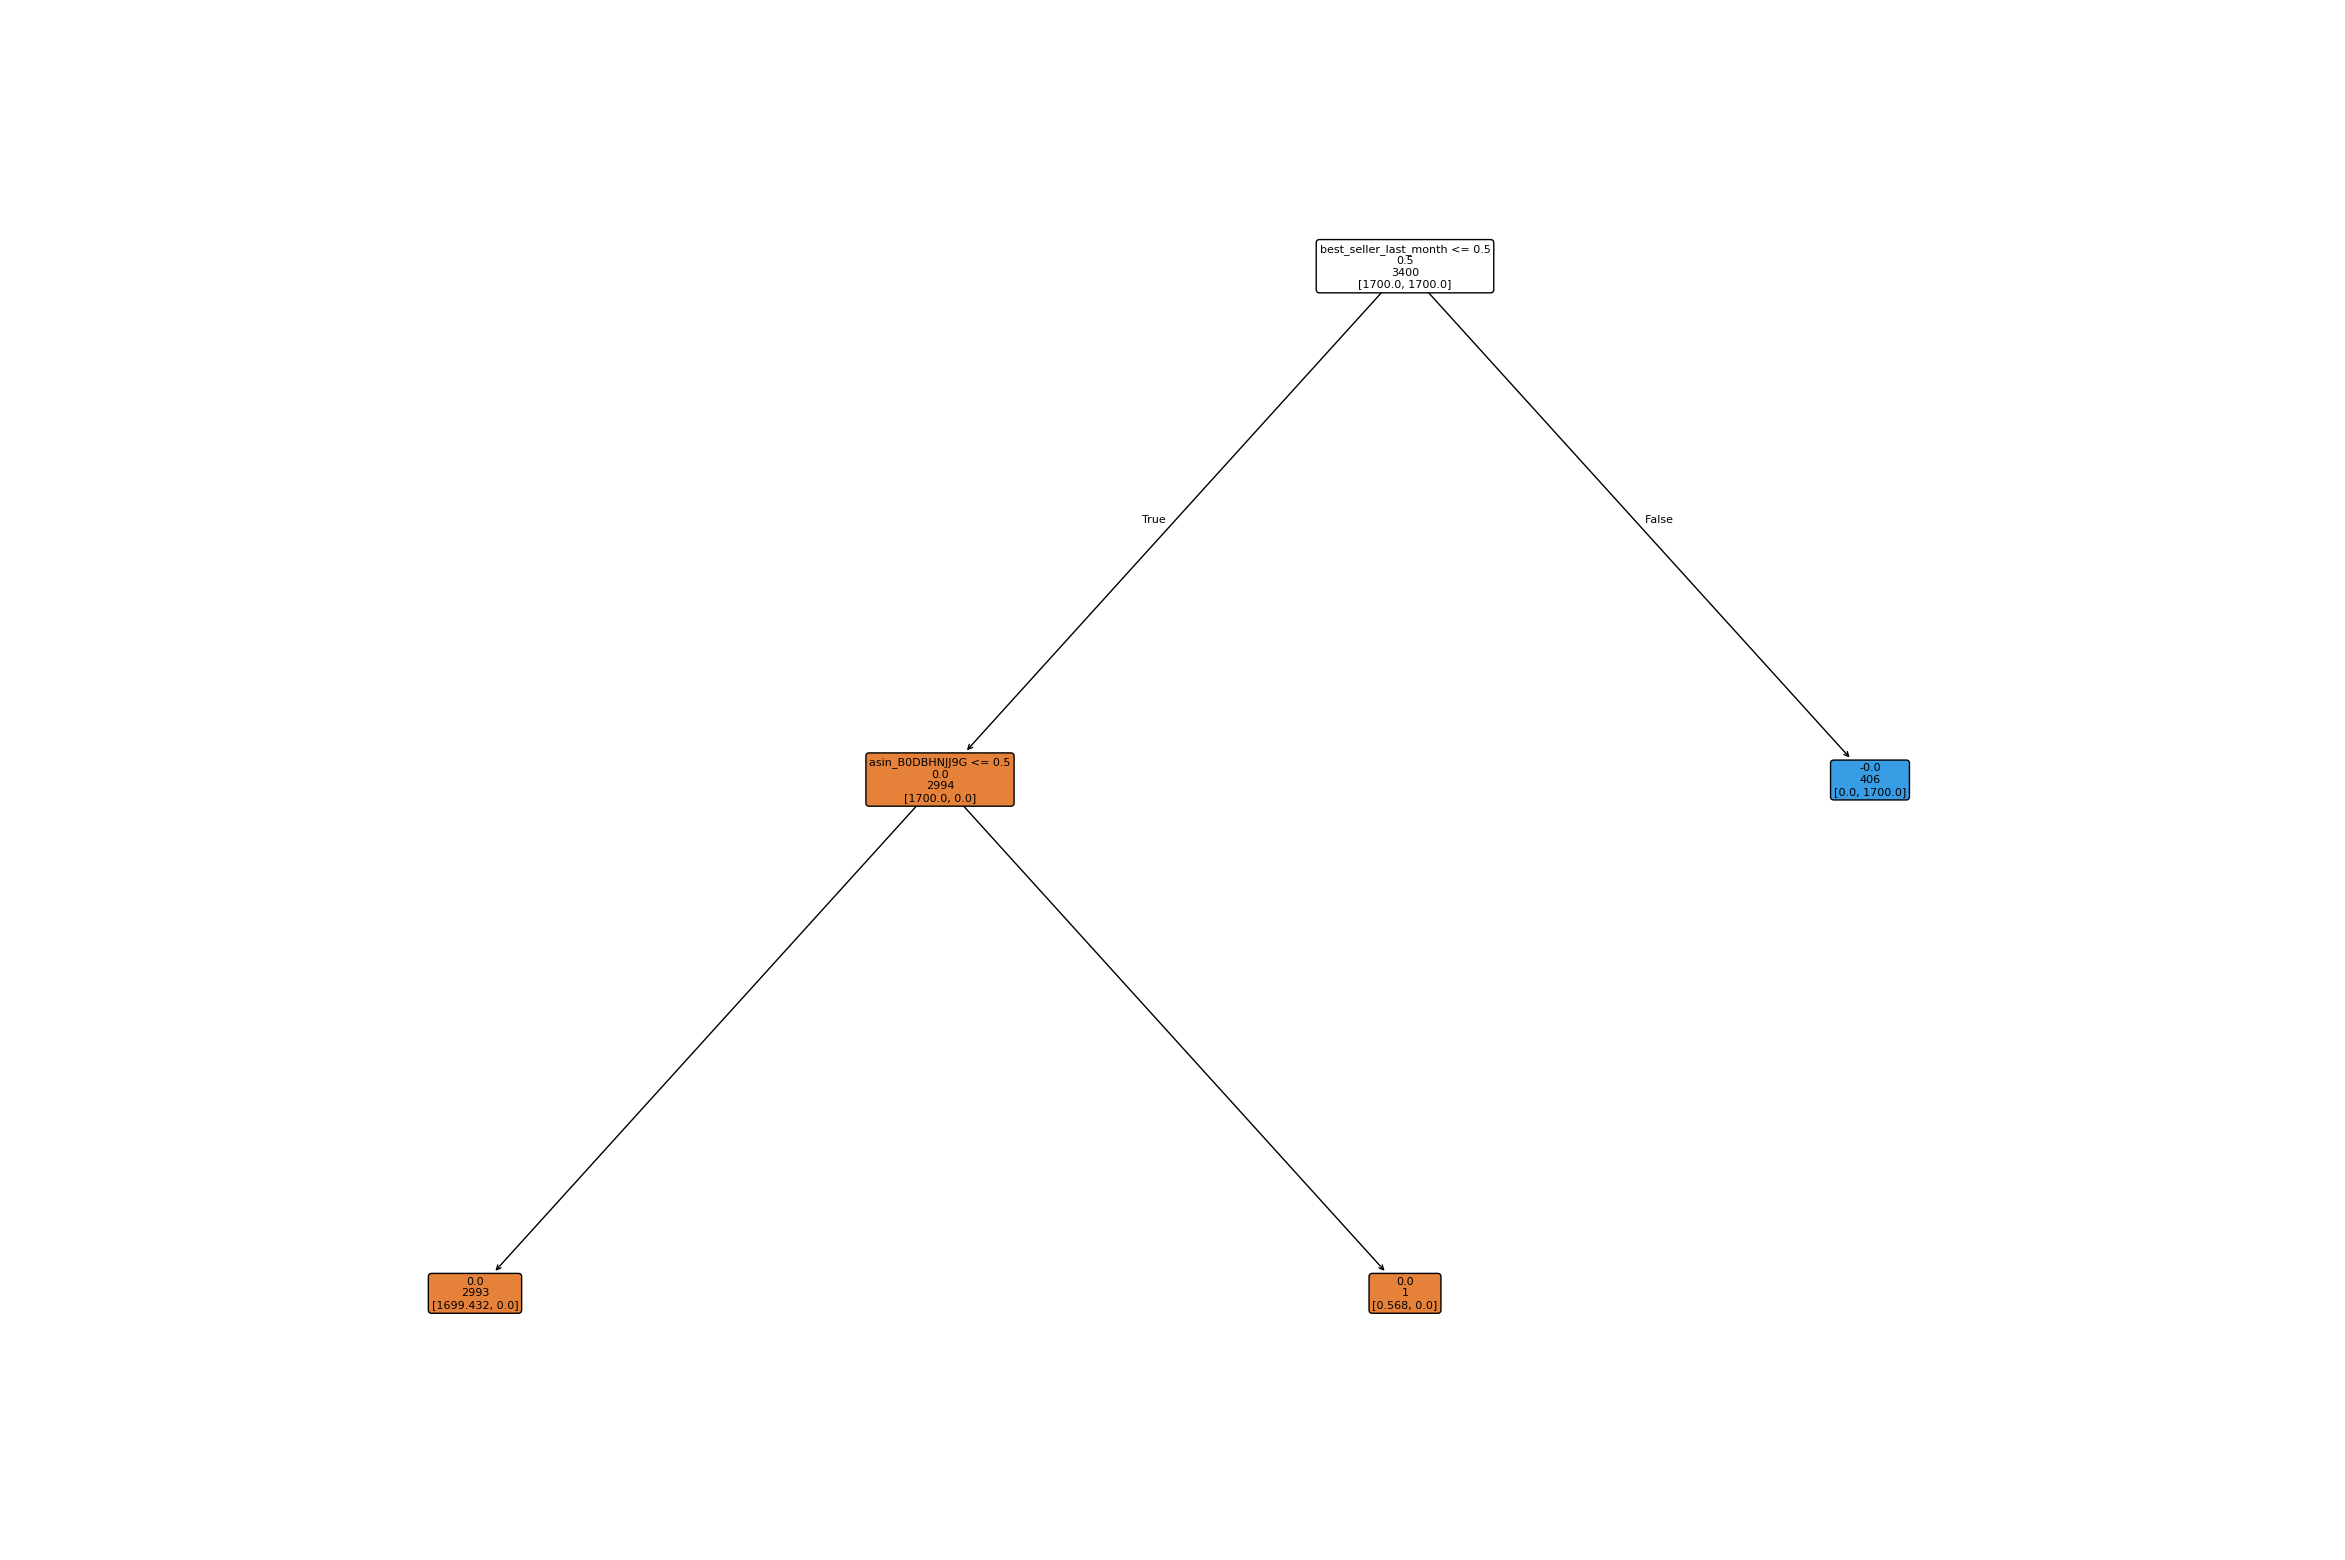


Tree Structure:
|--- best_seller_last_month <= 0.50
|   |--- asin_B0DBHNJJ9G <= 0.50
|   |   |--- class: False
|   |--- asin_B0DBHNJJ9G >  0.50
|   |   |--- class: False
|--- best_seller_last_month >  0.50
|   |--- class: True


Feature Importance Scores:
ratings: 0.0000
number_of_ratings: 0.0000
price: 0.0000
amazon_renewed: 0.0000
best_seller_last_month: 1.0000
asin_B000JCSBQY: 0.0000
asin_B000MXF2IK: 0.0000
asin_B000PEOLAG: 0.0000
asin_B000YLMLWA: 0.0000
asin_B0018BGEAA: 0.0000
asin_B002YDZSQM: 0.0000
asin_B0034THXTK: 0.0000
asin_B0034TZONM: 0.0000
asin_B003DKWX6I: 0.0000
asin_B003DQD5CS: 0.0000
asin_B003V4AJSU: 0.0000
asin_B0046LTU9G: 0.0000
asin_B004NLQWU4: 0.0000
asin_B004NLTWFG: 0.0000
asin_B004T36GCU: 0.0000
asin_B004UBOEZW: 0.0000
asin_B005SNNE1Q: 0.0000
asin_B00632QFIA: 0.0000
asin_B006ULGWPK: 0.0000
asin_B0073NZCEG: 0.0000
asin_B0076DIAIS: 0.0000
asin_B007I782J4: 0.0000
asin_B007VCRRNS: 0.0000
asin_B00812YWXU: 0.0000
asin_B008AFZ2J6: 0.0000
asin_B008HTJLF6: 0.0000
asin_B008

In [53]:
# Train a decision tree model on the training data
# If your dataset is highly imbalanced, the model might predict the majority class for all instances.
# An imbalanced dataset for a binary target variable like "returned" means that the number of cases of one class is much smaller or much larger than the number of cases of the other class.
# You can enable Class Weight Adjustment (class_weight='balanced') to adjust the class weights in the decision tree model to give more importance to the minority class.
# You can also adjust max_depth to decide the depth of the tree.
model = DecisionTreeClassifier(max_depth=4, class_weight='balanced')
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

from sklearn.metrics import precision_score, recall_score, f1_score
# Calculate precision, recall, and F1 score
precision = precision_score(y_test, y_pred, average='macro')  # or 'micro', 'weighted' depending on your need
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

feature_list = X_train.columns
# Plot the decision tree
plt.figure(figsize=(30, 20))
plot_tree(model, filled=True, label='none', feature_names=feature_list, rounded=True, fontsize=8)
plt.show()

# Display the decision tree strcutrue in text form (easier to read)
tree_rules = export_text(model, feature_names=list(feature_list))
print("\nTree Structure:")
print(tree_rules)

# Display the Feature Importance Scores
feature_list = X_train.columns
print("\nFeature Importance Scores:")
for name, importance in zip(feature_list, model.feature_importances_):
    print(f"{name}: {importance:.4f}")

**Interpretation of the results**

- Accuracy of a Decision Tree Model

The accuracy score of 0.3541 (approximately 35.41%) means that the model correctly predicted the outcome (Target Variable - Whether a product is returned or not) around 35.41% of the time. This is lower than the Logistic Regression model, which means that the accuracy of the Decision Tree model is low when compared to the Logistic Regression model.

- Precision, Recall, and F1 metrics

The results show that Precision equals 0.5137 (or approximately 51.37%). This means that out of all the products (order) the model predicted would be returned, approximately 51.37% of them actually were returned. This is slightly higher than the precision of the Logistic Regression model.

The results show that Recall equals 0.5516 (or approximately 55.16%). The model correctly identified 55.16% of the actual returned products. This means that out of all products that were actually returned, the model was able to identify nearly 55.16%. This is higher than the recall of the Logistic Regression model.

The results show that F1 Score equals 0.3079 (or approximately 30.79%). This score indicates that the Decision Tree model has a lower overall F1 Score than the Logistic Regression model, despite having a higher precision and recall. This means that the best model is the Logistic Regression model.

- Tree Structure

Start from the root node and follow the branches according to the decision rules until you reach a leaf node. Each path from the root to a leaf represents a series of decisions that lead to a prediction.

Features that appear closer to the root node are generally more important because they are used earlier in the decision-making process. These features have a greater impact on the model's predictions. For example, the decision tree structure highlights the quantity as the most significant predictor of whether an product will be returned.

- Feature Importance Scores

We display the feature importance scores in our Decision Tree model, with a focus on identifying the features that are most important in predicting product returns. Understanding feature importance helps identify which features are most significant in making predictions. Higher values indicate more important features.

Please note that feature importance in decision trees typically measures the contribution of each feature to the model's predictive performance. However, not all features listed in the Feature Importance Scores are included in the decision tree.

The features discount (0.4684), quantity (0.4289) and sales (0.0923) are the most significant predictors of whether a product will be returned. For instance, if we look at the decision tree, we can notice that if quantity is high (quantity >  0.45) and discount is low (discount <= 2.08), products are more likely to be returned.

Actionable insights: To address these findings, the company should consider tailoring their strategies based on quantities and discounts. We recommend the company to offer discounts on products purchased in large quantity.
